## Load data

In [1]:
import pandas as pd
from IPython.core.display import display

train = pd.read_csv('./emnist-letters-train.csv')
test = pd.read_csv('./emnist-letters-test.csv')

## Data inspection

In [2]:
# Inspect the data
# Each column besides the first one is representing a pixel (feature)
# 785 - 1 (the label) == 24 pixel x 24 pixels
train.head()

23  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.406  0.407  0.408  \
0   7  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  16  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  15  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  23  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  17  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.409  0.410  0.411  0.412  0.413  0.414  0.415  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]

In [3]:
# The shape shows that we are dealing with 88799 rows and 785 columns
train.shape

(88799, 785)

In [4]:
# The first column in the training set is called 23 and contains the labels - I want to see
# how many different values are present
number_of_unique_classes=train['23'].nunique()
display(number_of_unique_classes)

# Check if all feature values are between 0 and 255
valid_pixel_values = []
# Creating an array of numbers containing valid pixel values
for i in range(256):
    valid_pixel_values.append(i)
# Iterate through each column and validate its values with isin method
for i in range(train.shape[1]-1):
    valid = train[train.columns[i + 1]].isin(valid_pixel_values).all()
    if not valid:
        raise Exception("Invalid pixel value")

26

## Data preparation

In [5]:
# Give better column names
label_column_name = ['labels']
feature_columns = []
# Shape returns a tuple containing rows and columns. Here we access the column count on
# index 1 and subtract 1 (the label column) to get the amount of features
for i in range(train.shape[1]-1):
    feature_columns.append(i)
# Merge the two column name arrays
columns = label_column_name + feature_columns
# Apply columns to both datasets
train.columns = columns
test.columns = columns
## Split the datasets into x and y (x being features and y being labels)
x_train = train.drop("labels", 1)
y_train = train[["labels"]]
x_test = test.drop("labels",1)
y_test = test[["labels"]]

#Reshape the feature sets to a 2D array so I can view the images
x_train = x_train.values.reshape(-1,28,28, 1)
x_test=x_test.values.reshape(-1,28,28, 1)

C:\Users\Philip\AppData\Local\Temp/ipykernel_8280/2843166852.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train = train.drop("labels", 1)
C:\Users\Philip\AppData\Local\Temp/ipykernel_8280/2843166852.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_test = test.drop("labels",1)


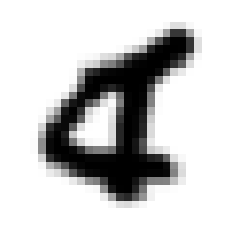

In [6]:
# Now reshaped - lets look at an image
import matplotlib.pyplot as plt
plt.imshow(x_test[4], cmap = "binary")
plt.axis('off')
plt.show()

In [7]:
## Look at the labels - to see if it matches
y_test.head()

labels
0       1
1       1
2       1
3       1
4       1

In [8]:
# Create validation sets from the training sets, which is used during training to evaluate
# different hyper parameters
x_valid, x_train = x_train[:5000], x_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

# Compute the mean for each pixel, which is used to standardize
# the inputs, which is needed for a self-normalizing network, which is
# a requirement for the SELU activation function, which is non-saturating
# and partially solves:
# - vanishing gradients problem
# - exploding gradients problem

# Mean is the average and axis 0 is row - axis 1 is column
pixel_means = x_train.mean(axis=0)
pixel_means

array([[[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [1.19333166e-05],
        [3.84252795e-03],
        [1.55729782e-02],
        [2.59072304e-02],
        [2.23511020e-02],
        [1.81386413e-02],
        [1.10025179e-02],
        [3.38906192e-03],
        [8.94998747e-04],
        [4.53466032e-04],
        [4.41532715e-04],
        [5.41772575e-03],
        [9.70178642e-03],
        [1.51911121e-02],
        [1.76374420e-02],
        [8.67552119e-03],
        [3.24586212e-03],
        [7.10032339e-03],
        [5.46545902e-03],
        [3.34132866e-04],
        [2.38666333e-05],
        [1.19333166e-05],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[0.00000000e+00],
        [1.31266483e-04],
        [4.98812635e-03],
        [3.36877528e-02],
        [8.42253488e-02],
        [1.64620103e-01],
        [2.51745248e-01],
        [3.13201828e-01],
        [3.44944450e-01],
        [3.47987446e-01],
        [2

In [9]:
# Compute the standard deviation for each pixel.
pixel_stds = x_train.std(axis=0)

In [10]:
import numpy as np
# Scale the inputs to mean 0 and standard deviation 1 to achieve self-normalization with SELU and LeCun.
x_train_standardized = (x_train - pixel_means) / pixel_stds

x_valid_standardized = (x_valid - x_valid.mean(axis=0)) / x_valid.std(axis=0)
x_test_standardized = (x_test - x_test.mean(axis=0)) / x_test.std(axis=0)

# Convert NaN to zero - happens because of 0 values being divided
x_train_standardized[np.isnan(x_train_standardized)] = 0
x_valid_standardized[np.isnan(x_valid_standardized)] = 0
x_test_standardized[np.isnan(x_test_standardized)] = 0

C:\Users\Philip\AppData\Local\Temp/ipykernel_8280/2158662798.py:3: RuntimeWarning: invalid value encountered in true_divide
  x_train_standardized = (x_train - pixel_means) / pixel_stds
C:\Users\Philip\AppData\Local\Temp/ipykernel_8280/2158662798.py:5: RuntimeWarning: invalid value encountered in true_divide
  x_valid_standardized = (x_valid - x_valid.mean(axis=0)) / x_valid.std(axis=0)
C:\Users\Philip\AppData\Local\Temp/ipykernel_8280/2158662798.py:6: RuntimeWarning: invalid value encountered in true_divide
  x_test_standardized = (x_test - x_test.mean(axis=0)) / x_test.std(axis=0)


In [11]:
# Validate that the mean is close to 0 for each pixel.
x_train_standardized.mean(axis=0)

array([[[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [-2.38475572e-18],
        [ 8.90308801e-19],
        [ 1.10228709e-18],
        [ 5.85060070e-18],
        [ 8.90308801e-19],
        [ 8.47913144e-19],
        [ 1.90780457e-18],
        [-2.14098069e-18],
        [ 5.08747887e-19],
        [-1.35666103e-18],
        [-2.75571772e-19],
        [-2.79811338e-18],
        [-2.54373943e-19],
        [ 7.63121830e-19],
        [ 7.20726173e-19],
        [ 5.80820504e-18],
        [ 4.23956572e-19],
        [-1.44145235e-18],
        [ 8.90308801e-19],
        [ 1.82301326e-18],
        [-1.12348492e-18],
        [-1.12348492e-18],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [ 1.31426537e-18],
        [-4.23956572e-18],
        [ 6.95288778e-18],
        [-1.14468274e-18],
        [-3.22206995e-18],
        [-1.83785174e-17],
        [ 1.67886803e-17],
        [ 1.28882798e-17],

In [12]:
# Validate that the standard deviation is close to 1 for each pixel.
x_train_standardized.std(axis=0)

array([[[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]],

       [[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
  

## Initialize model

In [13]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(30)
tf.random.set_seed(30)

def create_model(neuron_count, layer_count, output_neuron_count):
    model = keras.models.Sequential()
    # I use a Flatten layer as Input layer to convert each input 2D array to a 1-dimensional array
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    # Hidden layers
    for layer in range(layer_count):
        # I use SELU activation function and lecun as weight initializer, which is seen as one of the best
        # and it works well with SELU
        model.add(keras.layers.Dense(neuron_count, activation="selu", kernel_initializer="lecun_normal"))
    # To avoid overfitting I use Alpha Dropout as Regularization
    # which causes some neurons to be dropped during training (output 0)
    # The alpha variant is needed for SELU and LeCun
    model.add(keras.layers.AlphaDropout(rate=0.2))

    # Output layer.
    # Softmax activation function is used because it is multiclass classification.
    model.add(keras.layers.Dense(output_neuron_count, activation="softmax"))
    ## Compile the model
    # "sparse_categorical_crossentropy" is the loss function to use for classification when the classes are exclusive.
    # "sgd" means Stochastic Gradient Descent and is a type of Gradient Descent Algorithm
    # "accuracy" enables us to measure the accuracy during training and evaluation.
    # Momentum is set for momentum optimization which speeds up training by using previous gradients
    # which prevents very small learning steps near local minimum
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(momentum=0.5),
                  metrics=["accuracy"])
    return model

## Training

'Trying with layers: 1'

'And with neuron count: 50'

Epoch 1/100
2619/2619 [==============================] - 3s 1ms/step - loss: 1.4403 - accuracy: 0.5779 - val_loss: 0.9884 - val_accuracy: 0.7234 - lr: 0.0100

0.8205283880233765

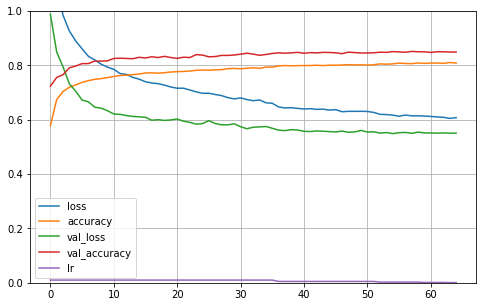

'Trying with layers: 1'

'And with neuron count: 100'

Epoch 1/100
2619/2619 [==============================] - 4s 1ms/step - loss: 1.3217 - accuracy: 0.6129 - val_loss: 0.9495 - val_accuracy: 0.7350 - lr: 0.0100

0.8532333374023438

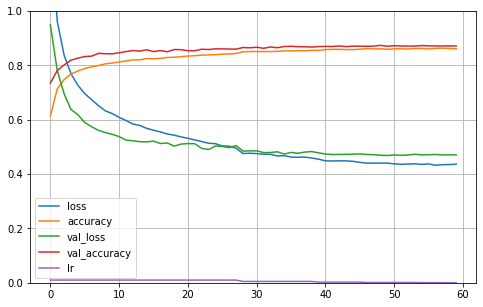

'Trying with layers: 1'

'And with neuron count: 150'

Epoch 1/100
2619/2619 [==============================] - 4s 1ms/step - loss: 1.2912 - accuracy: 0.6232 - val_loss: 0.9482 - val_accuracy: 0.7396 - lr: 0.0100

0.8574903607368469

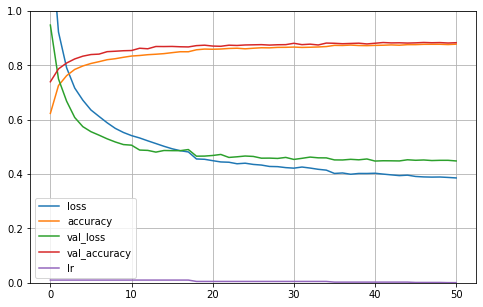

'Trying with layers: 2'

'And with neuron count: 50'

Epoch 1/100
2619/2619 [==============================] - 3s 1ms/step - loss: 1.3325 - accuracy: 0.6051 - val_loss: 0.8606 - val_accuracy: 0.7482 - lr: 0.0100

0.8513413071632385

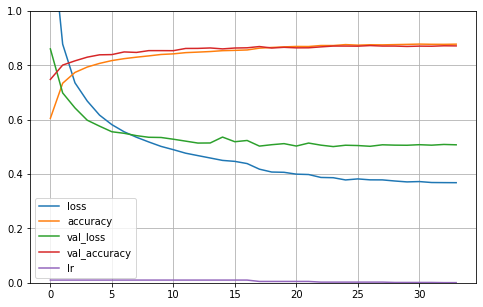

'Trying with layers: 2'

'And with neuron count: 100'

Epoch 1/100
2619/2619 [==============================] - 4s 1ms/step - loss: 1.2079 - accuracy: 0.6436 - val_loss: 0.7571 - val_accuracy: 0.7748 - lr: 0.0100

0.8721535205841064

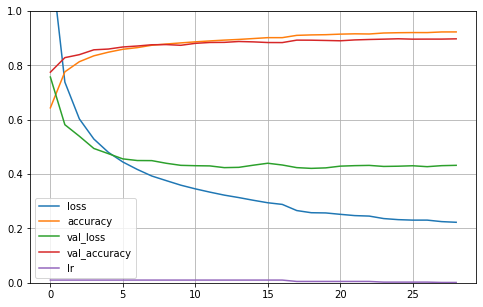

'Trying with layers: 2'

'And with neuron count: 150'

Epoch 1/100
2619/2619 [==============================] - 5s 2ms/step - loss: 1.1704 - accuracy: 0.6567 - val_loss: 0.7571 - val_accuracy: 0.7796 - lr: 0.0100

0.8730319738388062

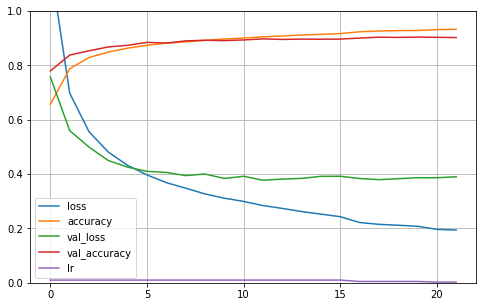

'Trying with layers: 5'

'And with neuron count: 50'

Epoch 1/100
2619/2619 [==============================] - 4s 1ms/step - loss: 1.1905 - accuracy: 0.6471 - val_loss: 0.7099 - val_accuracy: 0.7972 - lr: 0.0100

0.8568822145462036

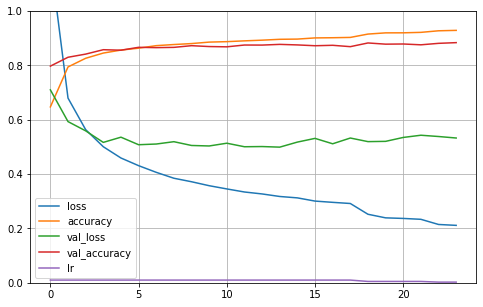

'Trying with layers: 5'

'And with neuron count: 100'

Epoch 1/100
2619/2619 [==============================] - 5s 2ms/step - loss: 1.0063 - accuracy: 0.7012 - val_loss: 0.6023 - val_accuracy: 0.8216 - lr: 0.0100

0.871680498123169

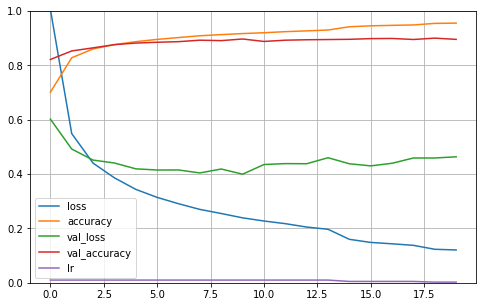

'Trying with layers: 5'

'And with neuron count: 150'

Epoch 1/100
2619/2619 [==============================] - 6s 2ms/step - loss: 0.9340 - accuracy: 0.7197 - val_loss: 0.5440 - val_accuracy: 0.8318 - lr: 0.0100

0.885330080986023

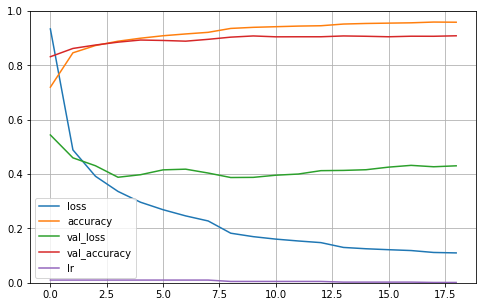

'Trying with layers: 10'

'And with neuron count: 50'

Epoch 1/100
2619/2619 [==============================] - 5s 2ms/step - loss: 1.1528 - accuracy: 0.6643 - val_loss: 0.7323 - val_accuracy: 0.7962 - lr: 0.0100

0.8587066531181335

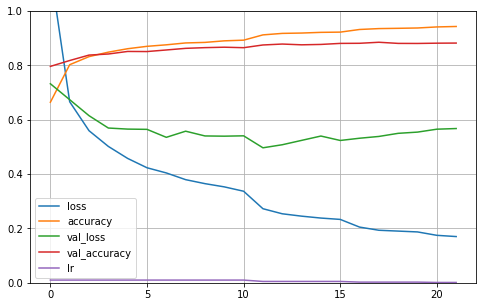

'Trying with layers: 10'

'And with neuron count: 100'

Epoch 1/100
2619/2619 [==============================] - 6s 2ms/step - loss: 0.9309 - accuracy: 0.7206 - val_loss: 0.6496 - val_accuracy: 0.8078 - lr: 0.0100

0.8601932525634766

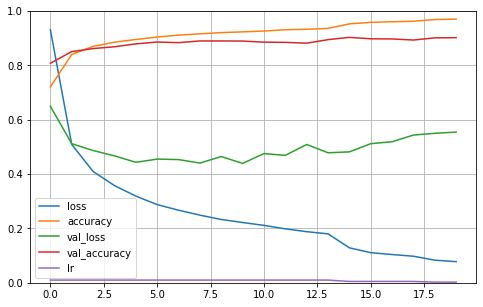

'Trying with layers: 10'

'And with neuron count: 150'

Epoch 1/100
2619/2619 [==============================] - 9s 3ms/step - loss: 0.8481 - accuracy: 0.7438 - val_loss: 0.5555 - val_accuracy: 0.8390 - lr: 0.0100

0.8886411190032959

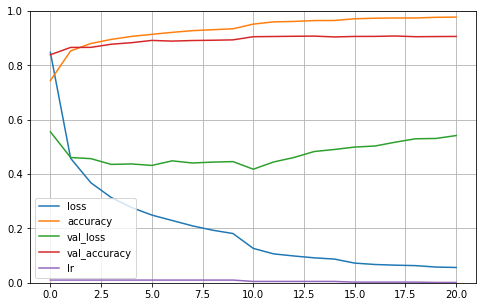

In [14]:
# These values are used to try out various combinations of hyper parameters
layers=[1,2,5,10]
neurons=[50,100,150]
output_neurons = number_of_unique_classes + 1

best_model = None
best_model_score = None
history = None

for l in layers:
    for n in neurons:
        display(f'Trying with layers: {l}')
        display(f'And with neuron count: {n}')
        temp_model=create_model(n,l, output_neurons)
        # Using early stopping to speed up training and avoid overfitting. If we see no gains after 10 epochs we stop training.
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        # Here I use Learning Rate Scheduling to vary learning rate during training
        # to find the best value.
        learning_rate_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4)
        temp_history = temp_model.fit(x_train_standardized, y_train, epochs=100, validation_data=(x_valid_standardized, y_valid), callbacks=[early_stopping_cb, learning_rate_scheduler])
        score=temp_model.evaluate(x_test_standardized, y_test)
        display(score[1])
        # Show the plotted history
        pd.DataFrame(temp_history.history).plot(figsize=(8, 5))
        plt.grid(True)
        plt.gca().set_ylim(0, 1)
        plt.show()

        if best_model is None:
            best_model=temp_model
            best_model_score=score[1]
            history = temp_history
        else:
            if best_model_score < score[1]:
                best_model=temp_model
                best_model_score=score[1]
                history = temp_history

## Evaluate the model

In [15]:
best_model.summary()
display(best_model_score)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_55 (Dense)            (None, 150)               117750    
                                                                 
 dense_56 (Dense)            (None, 150)               22650     
                                                                 
 dense_57 (Dense)            (None, 150)               22650     
                                                                 
 dense_58 (Dense)            (None, 150)               22650     
                                                                 
 dense_59 (Dense)            (None, 150)               22650     
                                                                 
 dense_60 (Dense)            (None, 150)             

0.8886411190032959

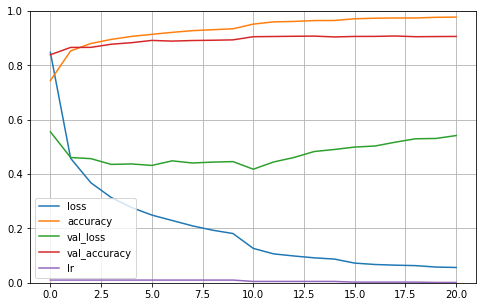

In [16]:
from matplotlib import pyplot as plt
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

